# Deep learning for HKL classification

## Library import

In [1]:
# Keras library is required 
# "conda install -c conda-forge keras" for anaconda distribution
# Currently CPU calculation is more than enough. GPU not really needed

In [1]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

## Keras import
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical

## LaueTools import
import LaueTools.dict_LaueTools as dictLT
import LaueTools.findorient as FO
import LaueTools.generaltools as GT
import LaueTools.lauecore as LT
import LaueTools.CrystalParameters as CP

-- OK! You are using python 3


## Defining useful functions

In [25]:
def get_material_data(material_="Cu", ang_maxx = 45, step = 0.5, hkl_ref=13, hklclass=11):
    """
    simplified routine from LaueTools to get only the closest angles as output
    For efficiency 
    To be simpler only Cubic materials are considered in the Following script
    Easily extendable for other symmetries as well!
    """
    a, b, c, alpha, beta, gamma = dictLT.dict_Materials[material_][1]
    Gstar = CP.Gstar_from_directlatticeparams(a, b, c, alpha, beta, gamma)
    rules = dictLT.dict_Materials[material_][-1]
    
    hkl2 = GT.threeindices_up_to(hkl_ref)
    hkl2 = CP.ApplyExtinctionrules(hkl2,rules)

    n = hklclass
    classhkl = []
    if material_ == "Cu":
        for i in range(1,n+1):
            for j in range(0,i+1):
                for k in range(0,j+1):
                    classhkl.append([i,j,k])
        classhkl = np.array(classhkl)
        classhkl = CP.ApplyExtinctionrules(classhkl, rules)
        classhkl = CP.FilterHarmonics_2(classhkl)  
        classhkl = np.array([classhkl_cubic(hkl) for hkl in classhkl])
    #%
    DEG = np.pi / 180.0
    query_angle = ang_maxx/2.
    angle_tol = ang_maxx/2.
    hkl1 = classhkl
    key_material = material_
    dictmaterials=dictLT.dict_Materials
    rules = (None, dictmaterials[key_material][2])
    latticeparams = dictmaterials[key_material][1]
    Gstar = CP.Gstar_from_directlatticeparams(*latticeparams)
    # compute square matrix containing angles
    metrics = Gstar
    H1 = hkl1
    n1 = hkl1.shape[0]
    H2 = hkl2
    n2 = hkl2.shape[0]
    
    dstar_square_1 = np.diag(np.inner(np.inner(H1, metrics), H1))
    dstar_square_2 = np.diag(np.inner(np.inner(H2, metrics), H2))
    scalar_product = np.inner(np.inner(H1, metrics), H2) * 1.0
    
    d1 = np.sqrt(dstar_square_1.reshape((n1, 1))) * 1.0
    d2 = np.sqrt(dstar_square_2.reshape((n2, 1))) * 1.0
    outy = np.outer(d1, d2)
    
    ratio = scalar_product / outy
    ratio = np.round(ratio, decimals=7)
    tab_angulardist = np.arccos(ratio) / DEG
    
    np.putmask(tab_angulardist, np.abs(tab_angulardist) < 0.001, 400)
    
    closest_angles_values = []
    for ang_ in trange(len(tab_angulardist)):
        tab_angulardist_ = tab_angulardist[ang_,:]
        angles_set = np.ravel(tab_angulardist_)  # 1D array
        sorted_ind = np.argsort(angles_set)
        sorted_angles = angles_set[sorted_ind]
        
        angle_query = angle_tol
        if isinstance(query_angle, (list, np.ndarray, tuple)):
            angle_query = query_angle[0]
        
        array_angledist = np.abs(sorted_angles - angle_query)
        pos_min = np.argmin(array_angledist)
        closest_angle = sorted_angles[pos_min]
        
        if np.abs(closest_angle - query_angle) > angle_tol:
            if angle_query > 0.5:
                pass
            print("Angle difference too low; take care here; no return")
            
        condition = array_angledist <= angle_tol
        closest_index_in_sorted_angles_raw = np.where(condition)[0]
        closest_angles_values.append(np.take(sorted_angles, closest_index_in_sorted_angles_raw))
    
    codebars = []
    angbins = np.arange(0,ang_maxx+step,step)
    angbins = np.arange(0,ang_maxx+step,step)
    angbins = np.arange(0,ang_maxx+step,step)
    #gaussspacing = 1/np.exp(-(np.linspace(0,45,501)-25)**2/2/17**2)
    #angbins = np.add.accumulate(gaussspacing)/420*45.
    
    for i in trange(len(closest_angles_values)):
        angles = closest_angles_values[i]
        fingerprint = np.histogram(angles, bins=angbins, density=False)[0]
        codebars.append(fingerprint)
    return codebars, angbins, classhkl

## Function to simulate Laue Patterns

In [26]:
def simulatemultiplepatterns(n, seed=1234, key_material=None, emax=23,
                             detectorparameters=None,
                             sortintensity = False):
    nbUBs=n
    np.random.seed(seed)
    UBelemagnles = np.random.random((3,nbUBs))*360-180.
    l_tth, l_chi, l_miller_ind, l_posx, l_posy, l_E, l_intensity = [],[],[],[],[],[],[]
    
    for angle_X, angle_Y, angle_Z in UBelemagnles.T:
        UBmatrix = GT.fromelemangles_toMatrix([angle_X, angle_Y, angle_Z])
        grain = CP.Prepare_Grain(key_material, UBmatrix)

        if detectorparameters is None:
            detectorparameters = [70.182, 1039.309, 944.122, 0.747, 0.071]
        s_tth, s_chi, s_miller_ind, s_posx, s_posy, s_E= LT.SimulateLaue_full_np(grain, 5, emax,
                                                                                 detectorparameters,
                                                                                 pixelsize=0.079142,
                                                                                 removeharmonics=0)
        s_intensity = 1./s_E
        l_tth.append(s_tth)
        l_chi.append(s_chi)
        l_miller_ind.append(s_miller_ind)
        l_posx.append(s_posx)
        l_posy.append(s_posy)
        l_E.append(s_E)
        l_intensity.append(s_intensity)
    #flat_list = [item for sublist in l for item in sublist]
    s_tth = np.array([item for sublist in l_tth for item in sublist])
    s_chi = np.array([item for sublist in l_chi for item in sublist])
    s_miller_ind = np.array([item for sublist in l_miller_ind for item in sublist])
    s_posx = np.array([item for sublist in l_posx for item in sublist])
    s_posy = np.array([item for sublist in l_posy for item in sublist])
    s_E = np.array([item for sublist in l_E for item in sublist])
    s_intensity=np.array([item for sublist in l_intensity for item in sublist])
    
    if sortintensity:
        indsort = np.argsort(s_intensity)[::-1]
        s_tth=np.take(s_tth, indsort)
        s_chi=np.take(s_chi, indsort)
        s_miller_ind=np.take(s_miller_ind, indsort, axis=0)
        s_posx=np.take(s_posx, indsort)
        s_posy=np.take(s_posy, indsort)
        s_E=np.take(s_E, indsort)
        s_intensity=np.take(s_intensity, indsort)
    return s_tth, s_chi, s_miller_ind,s_posx,s_posy

In [27]:
# Other helper funtions to limit the HKL indices
def spots_in_ROI(s_tth,s_chi,centerscattering=[70/2.,0],anglefromcenter=10.):
    """ return spot indices of spot lying in a given direction around a central direction"""
    # finding central spots
    s_the = s_tth/2.
    exp_s = np.array([s_the,s_chi]).T
    dist=GT.calculdist_from_thetachi(np.array([centerscattering]),exp_s).flatten()
    conddistin = dist<=anglefromcenter
    condtth = s_tth<70
    cond = np.logical_and(conddistin,condtth)
    #cond = np.logical_and(dist>anglefromcenter,condtth)
    spots_ix= np.where(cond)[0]
    return spots_ix

def classhkl_cubic(hkl):
    """ unique representation of hkl for cubic case
    """
    return sorted([abs(int(ind)) for ind in hkl])

def commonclass(hkl1, hkl2, material_):
    """ test if hkl1 and hkl2 belong to the same class"""
    if material_ == "Cu":
        cond1 = classhkl_cubic(hkl1)==classhkl_cubic(hkl2)
        cond2 = np.sum(np.cross(classhkl_cubic(hkl1),classhkl_cubic(hkl2))**2)==0.
    return cond1 or cond2

## Function to prepare laue patterns with required inputs

In [28]:
def prepare_LP(nbgrains, seednumber, material_,verbose,plotLauePattern):
    s_tth, s_chi, s_miller_ind, s_posx,s_posy = simulatemultiplepatterns(nbgrains,
                                                                        seed=seednumber,
                                                                        key_material=material_,
                                                                        sortintensity=True)
    spots_in_center = spots_in_ROI(s_tth,s_chi)
    if verbose:
        print('nb of central spots',len(spots_in_center))
        print('Central spots',spots_in_center)
    
    if plotLauePattern:
        figlaue, axlaue= plt.subplots()
        axlaue.scatter(s_tth,s_chi)
        axlaue.scatter(s_tth[spots_in_center],s_chi[spots_in_center], c="r")
        axlaue.set_title('nb matrices: %d, nb spots : %d'%(nbgrains,len(s_tth)))
    # considering all spots
    allspots_the_chi = np.transpose(np.array([s_tth/2., s_chi]))
    #print("Calculating all mutual angular distances of selected spots...")
    tabledistancerandom = np.transpose(GT.calculdist_from_thetachi(allspots_the_chi, allspots_the_chi))
    # ground truth
    hkl_sol = s_miller_ind
    return tabledistancerandom, hkl_sol, spots_in_center

## Define the architecture of the Neural Network

In [29]:
def model_arch(trainX, trainy):
    """
    Very simple and straight forward Neural Network with few hyperparameters
    straighforward RELU activation strategy with cross entropy to identify the HKL
    """
    n_bins, n_outputs = trainX.shape[1], trainy.shape[1]
    model = Sequential()
    model.add(keras.Input(shape=(n_bins,)))
    model.add(Dense(n_bins, activation='selu'))
    #model.add(Dropout(0.2))
    model.add(Dense((n_bins)//2, activation='selu'))
    #model.add(Dropout(0.2))
    model.add(Dense((n_bins)//2, activation='selu'))
    #model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Lets train the model

## generate data for model learning

In [30]:
## we generate Cu HKL's upto 9 indices with max angle of 45° and binning of 0.1°
## TODO include a multi binning dimensional data (i.e. with different binning strategy)
codebars, angbins, classhkl = get_material_data(material_="Cu", \
                                                   ang_maxx = 30, \
                                                   step = 0.1, \
                                                   hkl_ref=20, \
                                                   hklclass=20)
trainX = np.array(codebars)
#### Normalization-- Does not make significant difference
max_codebars = np.max(trainX, axis = 1)
trainX = trainX.T/ max_codebars
trainX = trainX.T
## convert HKL's to one hot encoding for NEURAL NETWORK (Also known as GROUND TRUTH)
trainy = np.array([i for i in range(len(classhkl))])
trainy = to_categorical(trainy)
print(trainX.shape, trainy.shape)
print(len(angbins))

100%|██████████| 378/378 [00:00<00:00, 20967.08it/s]

(378, 300) (378, 378)
301


## Let's train the model

In [ ]:
# try varying batch size and epochs
epochs = 1000
batch_size = 1
verbose = 1
model = model_arch(trainX, trainy)
# fit network
stats_model = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, shuffle=1, verbose=verbose)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_18 (Dense)             (None, 150)               45150     
_________________________________________________________________
dense_19 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_20 (Dense)             (None, 378)               57078     
Total params: 215,178
Trainable params: 215,178
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
378/378 [==============================] - 0s 509us/step - loss: 6.3591 - accuracy: 0.0000e+00
Epoch 2/1000
378/378 [==============================] - 0s 504us/step - loss: 5.8786 - accuracy: 0.0000e+00
Epoch 3/1000
378/378 [========

378/378 [==============================] - 0s 525us/step - loss: 8.1365e-08 - accuracy: 1.0000
Epoch 69/1000
378/378 [==============================] - 0s 546us/step - loss: 7.3165e-08 - accuracy: 1.0000
Epoch 70/1000
378/378 [==============================] - 0s 517us/step - loss: 7.3481e-08 - accuracy: 1.0000
Epoch 71/1000
378/378 [==============================] - 0s 507us/step - loss: 6.7173e-08 - accuracy: 1.0000
Epoch 72/1000
378/378 [==============================] - 0s 517us/step - loss: 8.3888e-08 - accuracy: 1.0000
Epoch 73/1000
378/378 [==============================] - 0s 522us/step - loss: 1.5566 - accuracy: 0.7063
Epoch 74/1000
378/378 [==============================] - 0s 520us/step - loss: 2.7456 - accuracy: 0.4603
Epoch 75/1000
378/378 [==============================] - 0s 514us/step - loss: 0.2602 - accuracy: 0.9392
Epoch 76/1000
378/378 [==============================] - 0s 512us/step - loss: 0.0881 - accuracy: 0.9788
Epoch 77/1000
378/378 [==========================

378/378 [==============================] - 0s 512us/step - loss: 1.9883e-04 - accuracy: 1.0000
Epoch 144/1000
378/378 [==============================] - 0s 512us/step - loss: 1.6216e-04 - accuracy: 1.0000
Epoch 145/1000
378/378 [==============================] - 0s 512us/step - loss: 1.3402e-04 - accuracy: 1.0000
Epoch 146/1000
378/378 [==============================] - 0s 518us/step - loss: 1.1137e-04 - accuracy: 1.0000
Epoch 147/1000
378/378 [==============================] - 0s 526us/step - loss: 9.3261e-05 - accuracy: 1.0000
Epoch 148/1000
378/378 [==============================] - 0s 520us/step - loss: 7.8420e-05 - accuracy: 1.0000
Epoch 149/1000
378/378 [==============================] - 0s 522us/step - loss: 6.6288e-05 - accuracy: 1.0000
Epoch 150/1000
378/378 [==============================] - 0s 522us/step - loss: 5.6215e-05 - accuracy: 1.0000
Epoch 151/1000
378/378 [==============================] - 0s 525us/step - loss: 4.7649e-05 - accuracy: 1.0000
Epoch 152/1000
378/378 [=

378/378 [==============================] - 0s 511us/step - loss: 0.1862 - accuracy: 0.9656
Epoch 219/1000
378/378 [==============================] - 0s 517us/step - loss: 0.0979 - accuracy: 0.9788
Epoch 220/1000
378/378 [==============================] - 0s 507us/step - loss: 0.0051 - accuracy: 0.9974
Epoch 221/1000
378/378 [==============================] - 0s 525us/step - loss: 1.4799e-05 - accuracy: 1.0000
Epoch 222/1000
378/378 [==============================] - 0s 504us/step - loss: 9.9272e-06 - accuracy: 1.0000
Epoch 223/1000
378/378 [==============================] - 0s 512us/step - loss: 8.2946e-06 - accuracy: 1.0000
Epoch 224/1000
378/378 [==============================] - 0s 517us/step - loss: 7.1880e-06 - accuracy: 1.0000
Epoch 225/1000
378/378 [==============================] - 0s 507us/step - loss: 6.3530e-06 - accuracy: 1.0000
Epoch 226/1000
378/378 [==============================] - 0s 515us/step - loss: 5.6275e-06 - accuracy: 1.0000
Epoch 227/1000
378/378 [=============

378/378 [==============================] - 0s 507us/step - loss: 1.8922e-09 - accuracy: 1.0000
Epoch 293/1000
378/378 [==============================] - 0s 507us/step - loss: 9.4611e-10 - accuracy: 1.0000
Epoch 294/1000
378/378 [==============================] - 0s 508us/step - loss: 1.1572 - accuracy: 0.8624
Epoch 295/1000
378/378 [==============================] - 0s 507us/step - loss: 2.2627 - accuracy: 0.6481
Epoch 296/1000
378/378 [==============================] - 0s 504us/step - loss: 0.2896 - accuracy: 0.9418
Epoch 297/1000
378/378 [==============================] - 0s 501us/step - loss: 0.1155 - accuracy: 0.9841
Epoch 298/1000
378/378 [==============================] - 0s 507us/step - loss: 0.0232 - accuracy: 0.9894
Epoch 299/1000
378/378 [==============================] - 0s 504us/step - loss: 0.0770 - accuracy: 0.9815
Epoch 300/1000
378/378 [==============================] - 0s 507us/step - loss: 0.0049 - accuracy: 0.9974
Epoch 301/1000
378/378 [=============================

378/378 [==============================] - 0s 528us/step - loss: 6.3074e-10 - accuracy: 1.0000
Epoch 367/1000
378/378 [==============================] - 0s 530us/step - loss: 6.3074e-10 - accuracy: 1.0000
Epoch 368/1000
378/378 [==============================] - 0s 524us/step - loss: 7.2535e-09 - accuracy: 1.0000
Epoch 369/1000
378/378 [==============================] - 0s 536us/step - loss: 2.4353 - accuracy: 0.7381
Epoch 370/1000
378/378 [==============================] - 0s 528us/step - loss: 1.8681 - accuracy: 0.7381
Epoch 371/1000
378/378 [==============================] - 0s 530us/step - loss: 0.1946 - accuracy: 0.9603
Epoch 372/1000
378/378 [==============================] - 0s 530us/step - loss: 0.0405 - accuracy: 0.9894
Epoch 373/1000
378/378 [==============================] - 0s 619us/step - loss: 4.7660e-04 - accuracy: 1.0000
Epoch 374/1000
378/378 [==============================] - 0s 654us/step - loss: 4.6600e-05 - accuracy: 1.0000
Epoch 375/1000
378/378 [=================

## Plot the losses and accuracy of Training

Accuracy:  0.7148514986038208
Loss:  0.7245466709136963


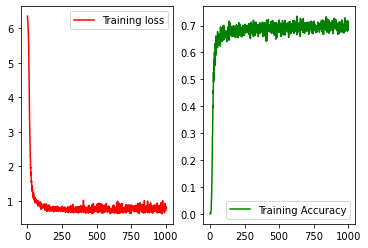

In [21]:
print( "Accuracy: ", stats_model.history['accuracy'][-1])
print( "Loss: ", stats_model.history['loss'][-1])

epochs = range(1, len(model.history.history['loss']) + 1)
fig, ax = plt.subplots(1,2)
ax[0].plot(epochs, model.history.history['loss'], 'r', label='Training loss')
ax[0].legend()
ax[1].plot(epochs, model.history.history['accuracy'], 'g', label='Training Accuracy')
ax[1].legend()

# Prediction time

## single prediction

In [22]:
nbgrains = 1
material_ = "Cu"
verbose = 0

seednumber = np.random.randint(10000000)

tabledistancerandom, hkl_sol, spots_in_center = prepare_LP(nbgrains, 
                                                            seednumber, 
                                                            material_,
                                                            verbose,
                                                            plotLauePattern=False)
if len(spots_in_center) == 0:
    print("No spots in center")
    
for i in spots_in_center: ## identify the center HKL spots 
    spotangles = tabledistancerandom[i]
    spotangles = np.delete(spotangles, i)# removing the self distance
    codebars = np.histogram(spotangles, bins=angbins)[0]
    max_codebars = np.max(codebars)
    codebars = codebars/ max_codebars
    codebars = codebars.reshape((1,len(codebars)))
    ## prediction routine here
    prediction = model.predict(codebars)
    class_predicted = np.argmax(prediction, axis = 1)
    ## verify prediction
    isgoodprediction = commonclass(classhkl[class_predicted][0],hkl_sol[i],material_)
    if isgoodprediction:
        print("Prediction is GOOD")
    elif not isgoodprediction:
        print("Prediction is BAD")
    print("Actual HKL is "+ str(hkl_sol[i]))
    print("Predicted HKL is "+ str(classhkl[class_predicted][0]))
    print("**********************************")

Prediction is BAD
Actual HKL is [-1 -5 -3]
Predicted HKL is [19 13  9]
**********************************


## Batch prediction to get some stats

In [23]:
nbgrains = 1
material_ = "Cu"
verbose = 0
nbtestspots = 0
nb_goods = 0
nb_wrongs = 0
bad_prediction_hkl = []

for _ in trange(100):
    seednumber = np.random.randint(10000000)

    tabledistancerandom, hkl_sol, spots_in_center = prepare_LP(nbgrains, 
                                                                seednumber, 
                                                                material_,
                                                                verbose,
                                                                plotLauePattern=False)
    nbtestspots = nbtestspots + len(spots_in_center)
    for i in spots_in_center: ## identify the center HKL spots 
        spotangles = tabledistancerandom[i]
        spotangles = np.delete(spotangles, i)# removing the self distance
        codebars = np.histogram(spotangles, bins=angbins)[0]
        max_codebars = np.max(codebars)
        codebars = codebars/ max_codebars
        codebars = codebars.reshape((1,len(codebars)))
        
        prediction = model.predict(codebars)
        class_predicted = np.argmax(prediction, axis = 1)
        
        isgoodprediction = commonclass(classhkl[class_predicted][0],hkl_sol[i],material_)
        if isgoodprediction:
            nb_goods += 1
        elif not isgoodprediction:
            nb_wrongs += 1
            bad_prediction_hkl.append((classhkl[class_predicted][0], hkl_sol[i]))
            
        if verbose:
            print("Actual HKL is "+ str(hkl_sol[i]))
            print("Predicted HKL is "+ str(classhkl[class_predicted][0]))
            print('goodprediction ',isgoodprediction)
            print("**********************************")
        
print("***********")        
print('Total Prediction: ',nbtestspots) 
print('GOOD Prediction: ',nb_goods)    
print('BAD Prediction: ',nb_wrongs) 


100%|██████████| 100/100 [00:03<00:00, 28.79it/s]

***********
Total Prediction:  132
GOOD Prediction:  39
BAD Prediction:  93
